<a href="https://colab.research.google.com/github/ryoungj/ObsScaling/blob/main/base_llm_post_training.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Post-Training Scaling Analysis

This notebook shows how to apply observational scaling laws to analyze the scaling of post-training techniques like Chain-of-Thought and Self-Consistency, corresponding to the Sec 4.3 of the paper.

## Preparation

Colab specific setup: uncomment the following lines in colab

In [1]:
# ! git clone https://github.com/ryoungj/ObsScaling
# %cd ObsScaling
# ! pip install -r requirements.txt

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import re
import copy

from utils import *

In [3]:
%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Load Eval Data

Load benchmark eval results for base LLMs

In [4]:
base_llm_benchmark_eval = load_base_llm_benchmark_eval()

In [5]:
base_llm_benchmark_eval

Model    Model Family  Model Size (B)  \
0               meta-llama/Llama-2-7b-hf         Llama-2             7.0   
1              meta-llama/Llama-2-13b-hf         Llama-2            13.0   
2              meta-llama/Llama-2-70b-hf         Llama-2            70.0   
3                    huggyllama/llama-7b           Llama             6.7   
4                   huggyllama/llama-13b           Llama            13.0   
..                                   ...             ...             ...   
72                 bigcode/starcoder2-7b      StarCoder2             7.0   
73                 bigcode/starcoder2-3b      StarCoder2             3.0   
74  deepseek-ai/deepseek-coder-1.3b-base  DeepSeek-Coder             1.3   
75  deepseek-ai/deepseek-coder-6.7b-base  DeepSeek-Coder             6.7   
76   deepseek-ai/deepseek-coder-33b-base  DeepSeek-Coder            33.0   

    Pretraining Data Size (T)  FLOPs (1E21)      MMLU     ARC-C  HellaSwag  \
0                         2.0          84.0  0.437961  0.530717   0.777435   
1                         2.0         156.0  0.543378  0.581058   0.809699   
2                         2.0         840.0  0.698321  0.673208   0.873332   
3                         1.0          40.2  0.356933  0.509386   0.778132   
4                         1.0          78.0  0.476106  0.561433   0.809201   
..                        ...           ...       ...       ...        ...   
72                        3.7         155.4  0.412133  0.383106   0.519120   
73                        3.3          59.4  0.386486  0.345563   0.476200   
74                        2.0          15.6  0.260247  0.257679   0.392750   
75                        2.0          80.4  0.383914  0.370307   0.534555   
76                        2.0         396.0  0.409137  0.424915   0.599881   

    Winograd  TruthfulQA     GSM8K  XWinograd  HumanEval  
0   0.740331    0.389802  0.144807   0.754881   0.128049  
1   0.766377    0.341724  0.228203   0.786798   0.182927  
2   0.837411    0.449235  0.540561   0.824453   0.298780  
3   0.714286    0.343279  0.080364   0.693204   0.128049  
4   0.762431    0.394789  0.075815   0.730362   0.158537  
..       ...         ...       ...        ...        ...  
72  0.591949    0.419935  0.250948   0.620090   0.354000  
73  0.545383    0.404870  0.196361   0.603683   0.317000  
74  0.527230    0.426137  0.029568   0.606346   0.287000  
75  0.580900    0.402813  0.179682   0.678871   0.476000  
76  0.624309    0.399702  0.300227   0.696132   0.512000  

[77 rows x 13 columns]

Load post-training eval results for base LLMs

In [6]:
eval_result_path = "./eval_results/base_llm_post_training_eval.csv"

post_training_eval = pd.read_csv(eval_result_path)

Merge eval results

In [7]:
base_llm_eval_with_post_training = pd.merge(base_llm_benchmark_eval, post_training_eval, on="Model")

## Scaling Analysis

Setup arguments

In [8]:
SCALING_SETUP_KWARGS = {
    # Data preprocessing: PCA imputation and extraction
    **NONGSM_PCA_PREPROCESS_KWARGS,  # exclude GSM to avoid making the task trivial, e.g., using GSM to predict GSM
    
    # Non-lineariy: sigmoid with parametrized scale and shift
    "nonlinearity": "sigmoid-parametric", 

    # Cutoff: 8.4E22 FLOPs corresponding to LLama-2 7B
    "split_method": "cutoff_by_FLOPs (1E21)",
    "cutoff_threshold": 84,

    # Model families: include all we have evaled
    "df_filter": lambda x: x['Model Family'].isin(EVAL_BASE_MODEL_FAMILIES),   
    "df_groupby": 'Model Family',  # group markers by model family

    # Regression: ordinary least squares
    "reg_method": "robust",  
    "reg_kwargs": {"delta": 1.0},  # huber loss with delta=1.0 for normalized target within [0, 1] reduces to OLS
}

In [9]:
PLOT_X_METRICS_LIST = [MODEL_SIZE_METRIC, TRAINING_FLOPS_METRIC, PC_METRIC_NUM_3]   # plot scaling comparison w.r.t. model size, training FLOPs, and 3 PCs

### GSM8K

#### Setup

Specify downstream metrics for analysis

In [10]:
## GSM8K eval metrics with CoT and self-consistency
GSM8K_METHOD_SCALING_COT_METRIC_MAP = {
    'gsm8k_5_exact_match,flexible-extract': "Naive + Greedy",
    'gsm8k_cot_8_exact_match,flexible-extract': "CoT + Greedy",
}

GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP = {
    'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract': "CoT + 1 Sample",
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract': "CoT + SC + 5 Samples",
}

GSM8K_METHOD_SCALING_ORIG_METRIC_MAP = {
    **GSM8K_METHOD_SCALING_COT_METRIC_MAP,
    **GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP,
}

GSM8K_COT_SCALING_METRICS = list(GSM8K_METHOD_SCALING_COT_METRIC_MAP.keys())
GSM8K_SELFCONS_SCALING_METRICS = list(GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP.keys())

GSM8K_METHOD_SCALING_METRICS = [
    'gsm8k_5_exact_match,flexible-extract',
    'gsm8k_cot_8_exact_match,flexible-extract',
    # 'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract',
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract',
]

Plot styling

In [11]:
color_palette = sns.color_palette()

GSM8K_METHOD_SCALING_COLOR_MAP = {
    'gsm8k_5_exact_match,flexible-extract': color_palette[1],
    'gsm8k_cot_8_exact_match,flexible-extract': color_palette[0],
    'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract': color_palette[0],
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract': color_palette[2],
}


GSM8K_SETUP_SPECIFIC_KWARGS = {}
for e in GSM8K_METHOD_SCALING_METRICS:
    GSM8K_SETUP_SPECIFIC_KWARGS[e] = {
        "plot_adjust_kwargs": {"title": GSM8K_METHOD_SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
    }

    if e != "gsm8k_5_exact_match,flexible-extract":
        GSM8K_SETUP_SPECIFIC_KWARGS[e]["plot_adjust_kwargs"].update({"ylim": [-0.03, 0.97]})
    if e in ["gsm8k_5_exact_match,flexible-extract"]:
        GSM8K_SETUP_SPECIFIC_KWARGS[e]["grace_range_ratios"] = [0.05, 0.12]


#### Scaling Predictions

Compare the scaling predictions with observation scaling laws (PCs) and with compute scaling laws (model size or training FLOPs)

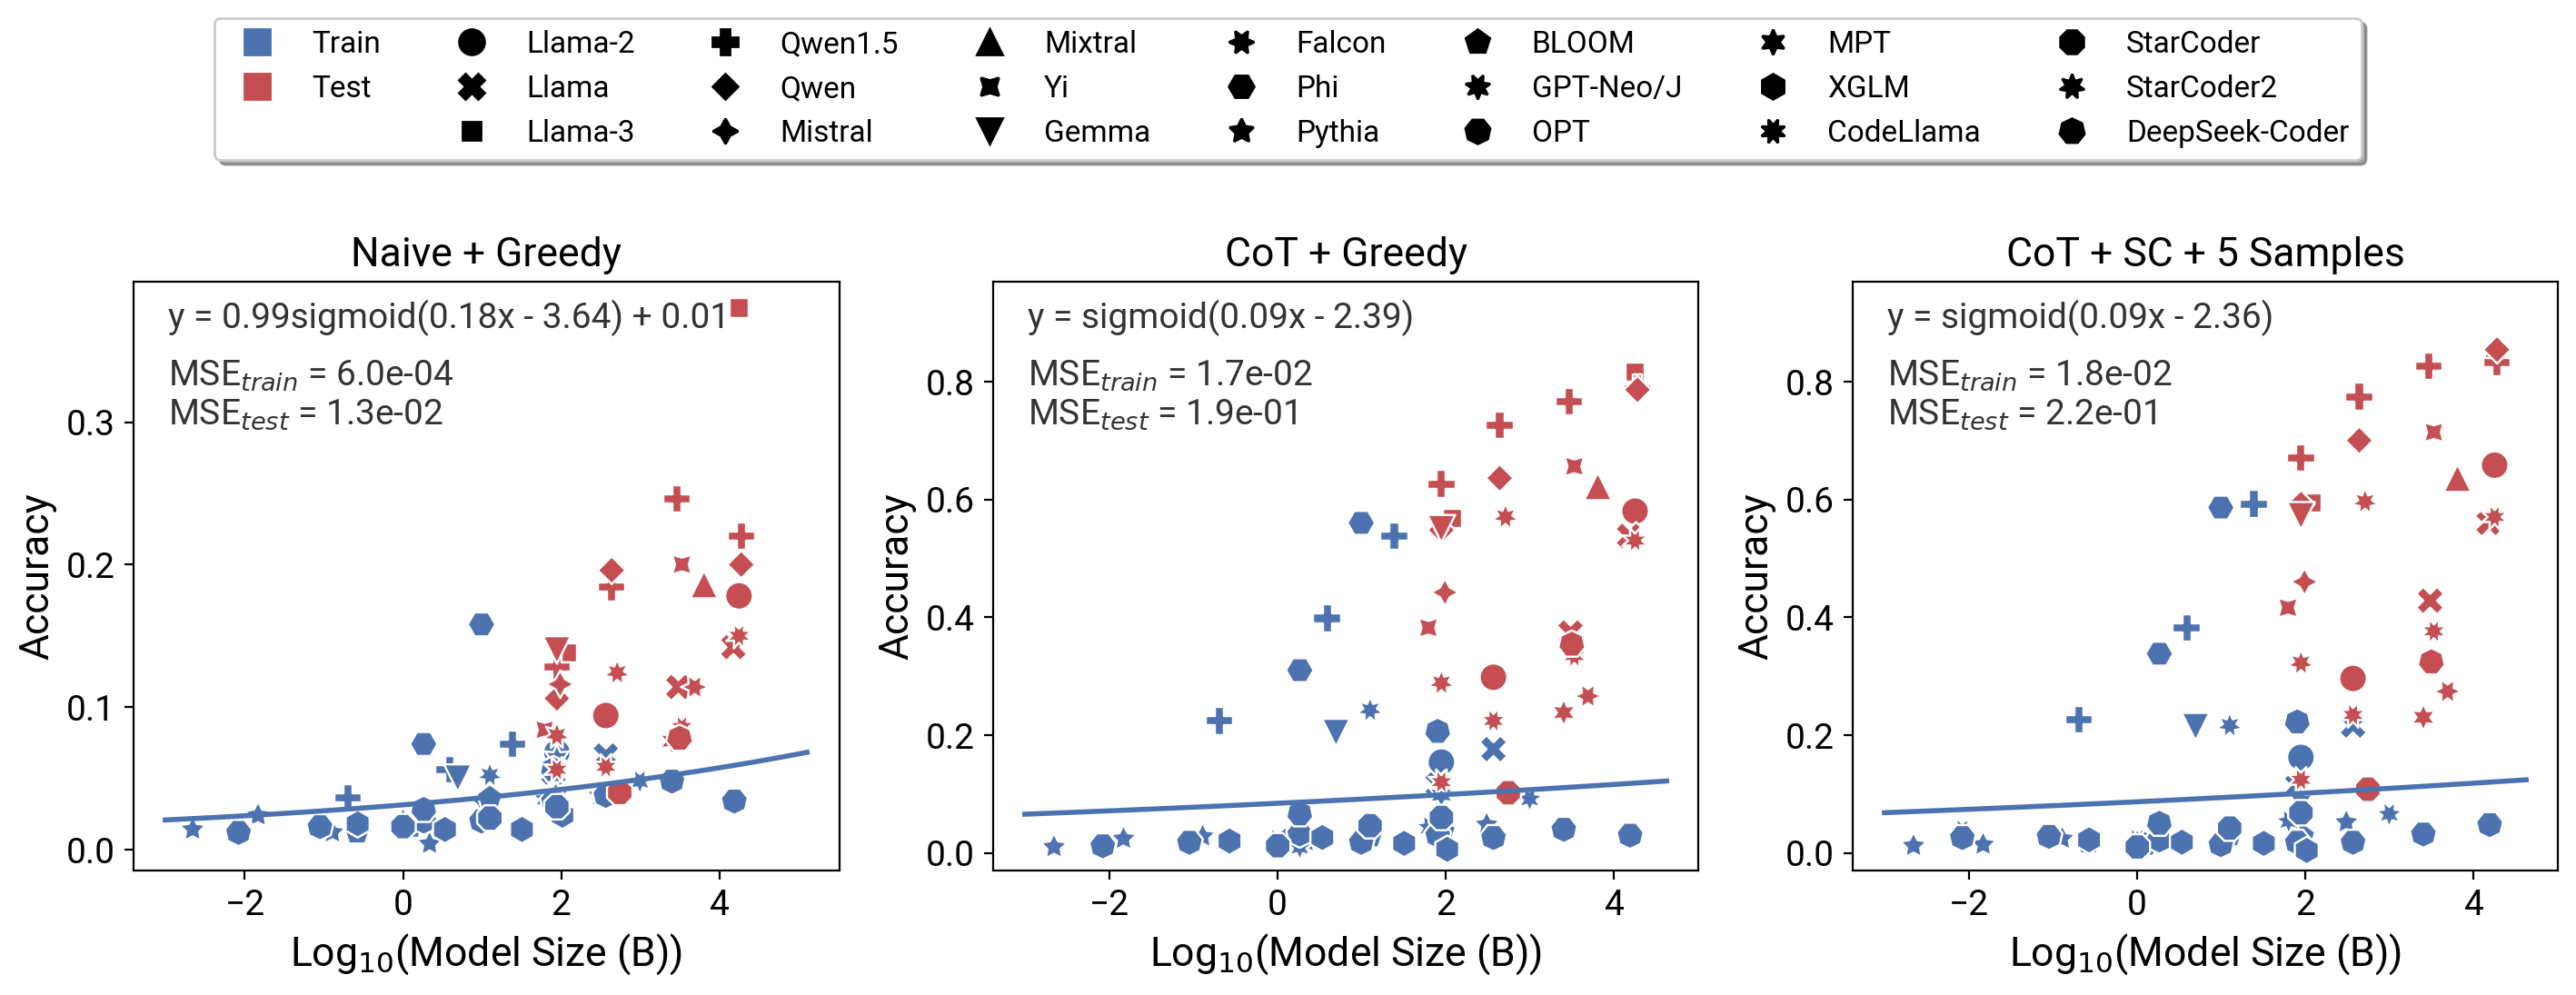

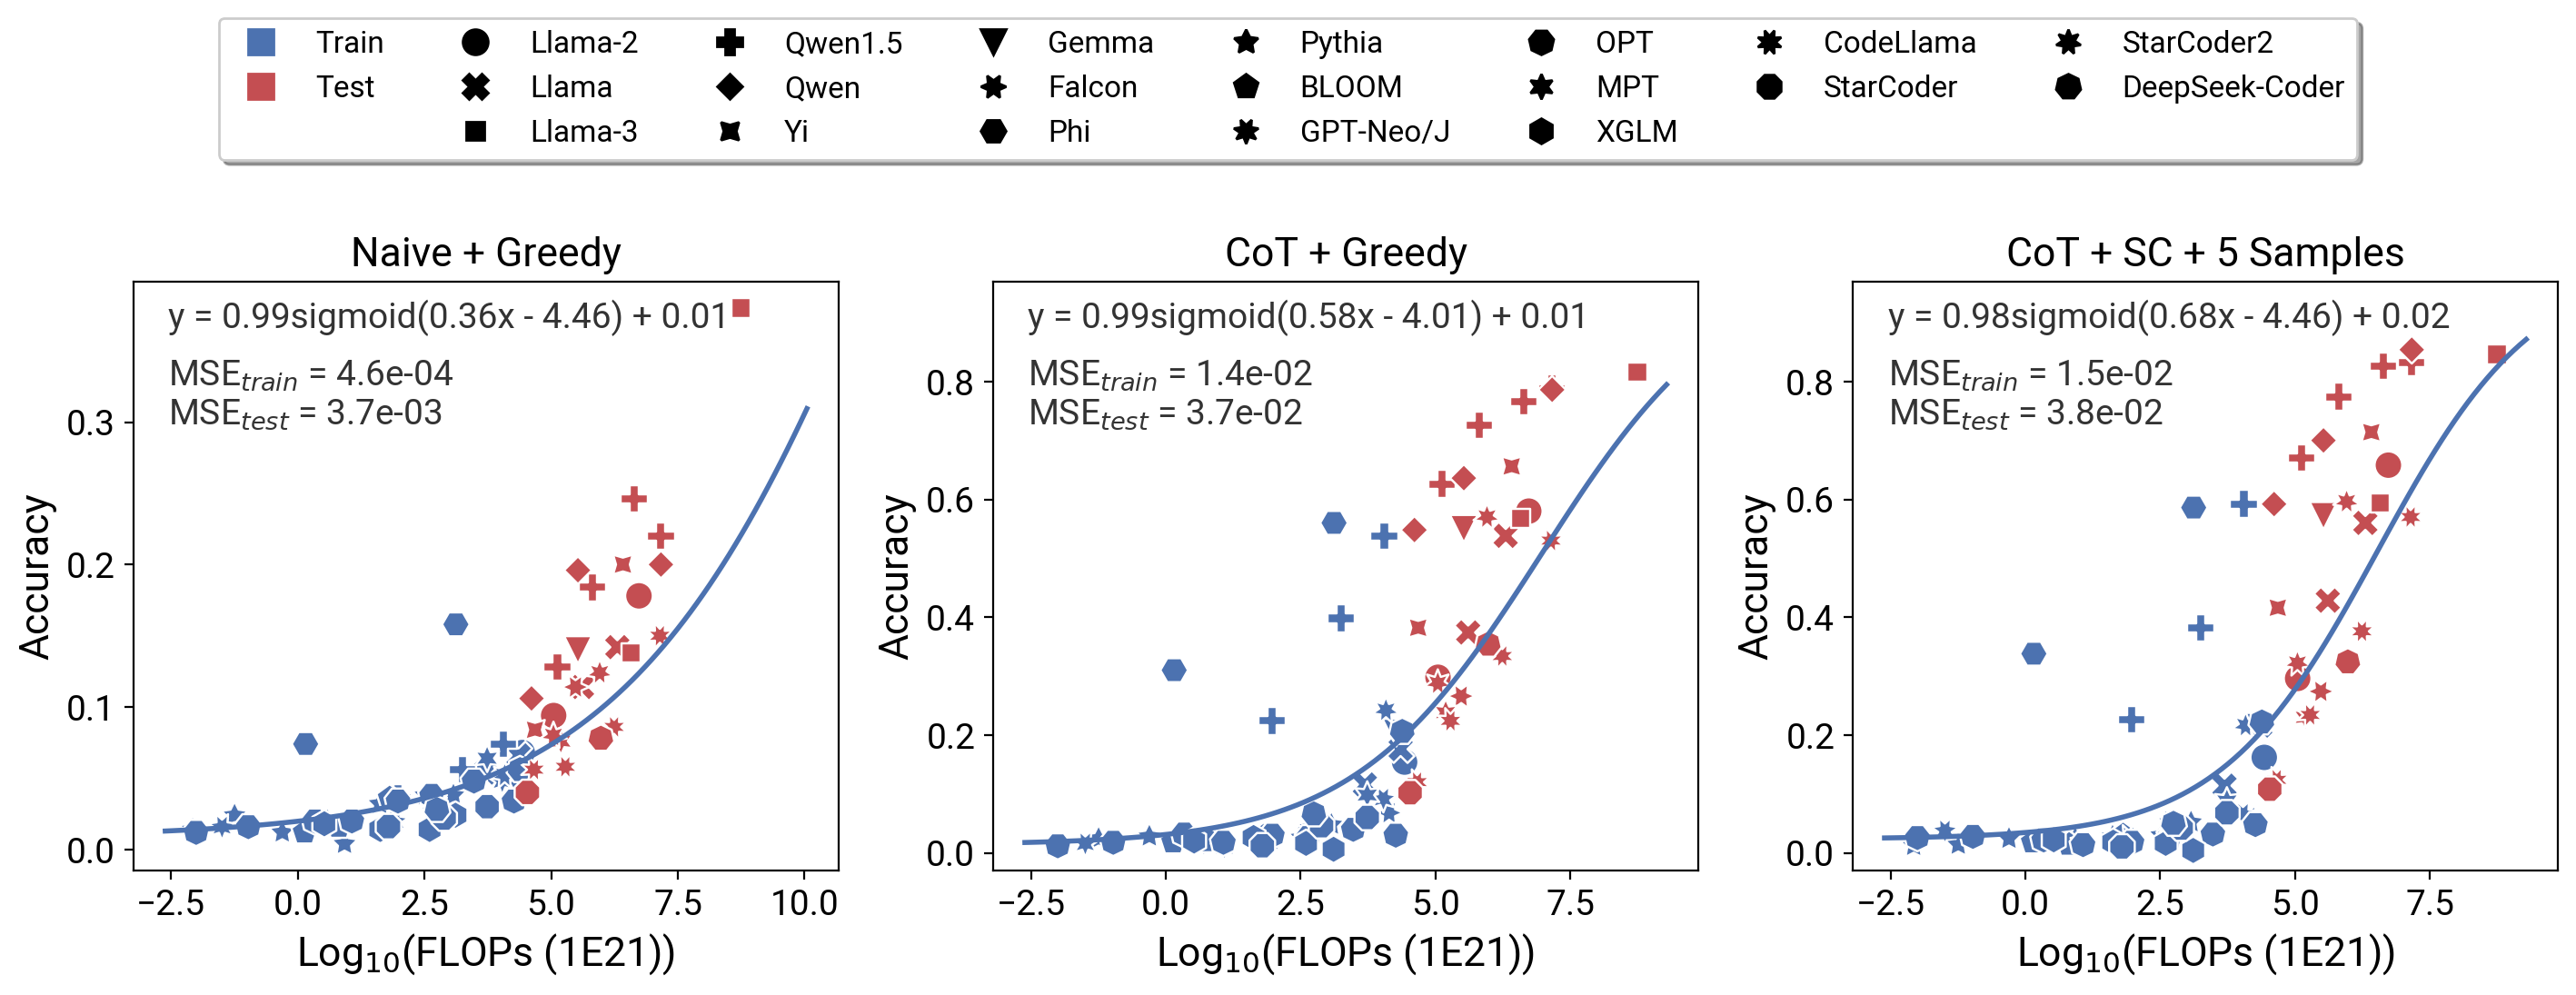

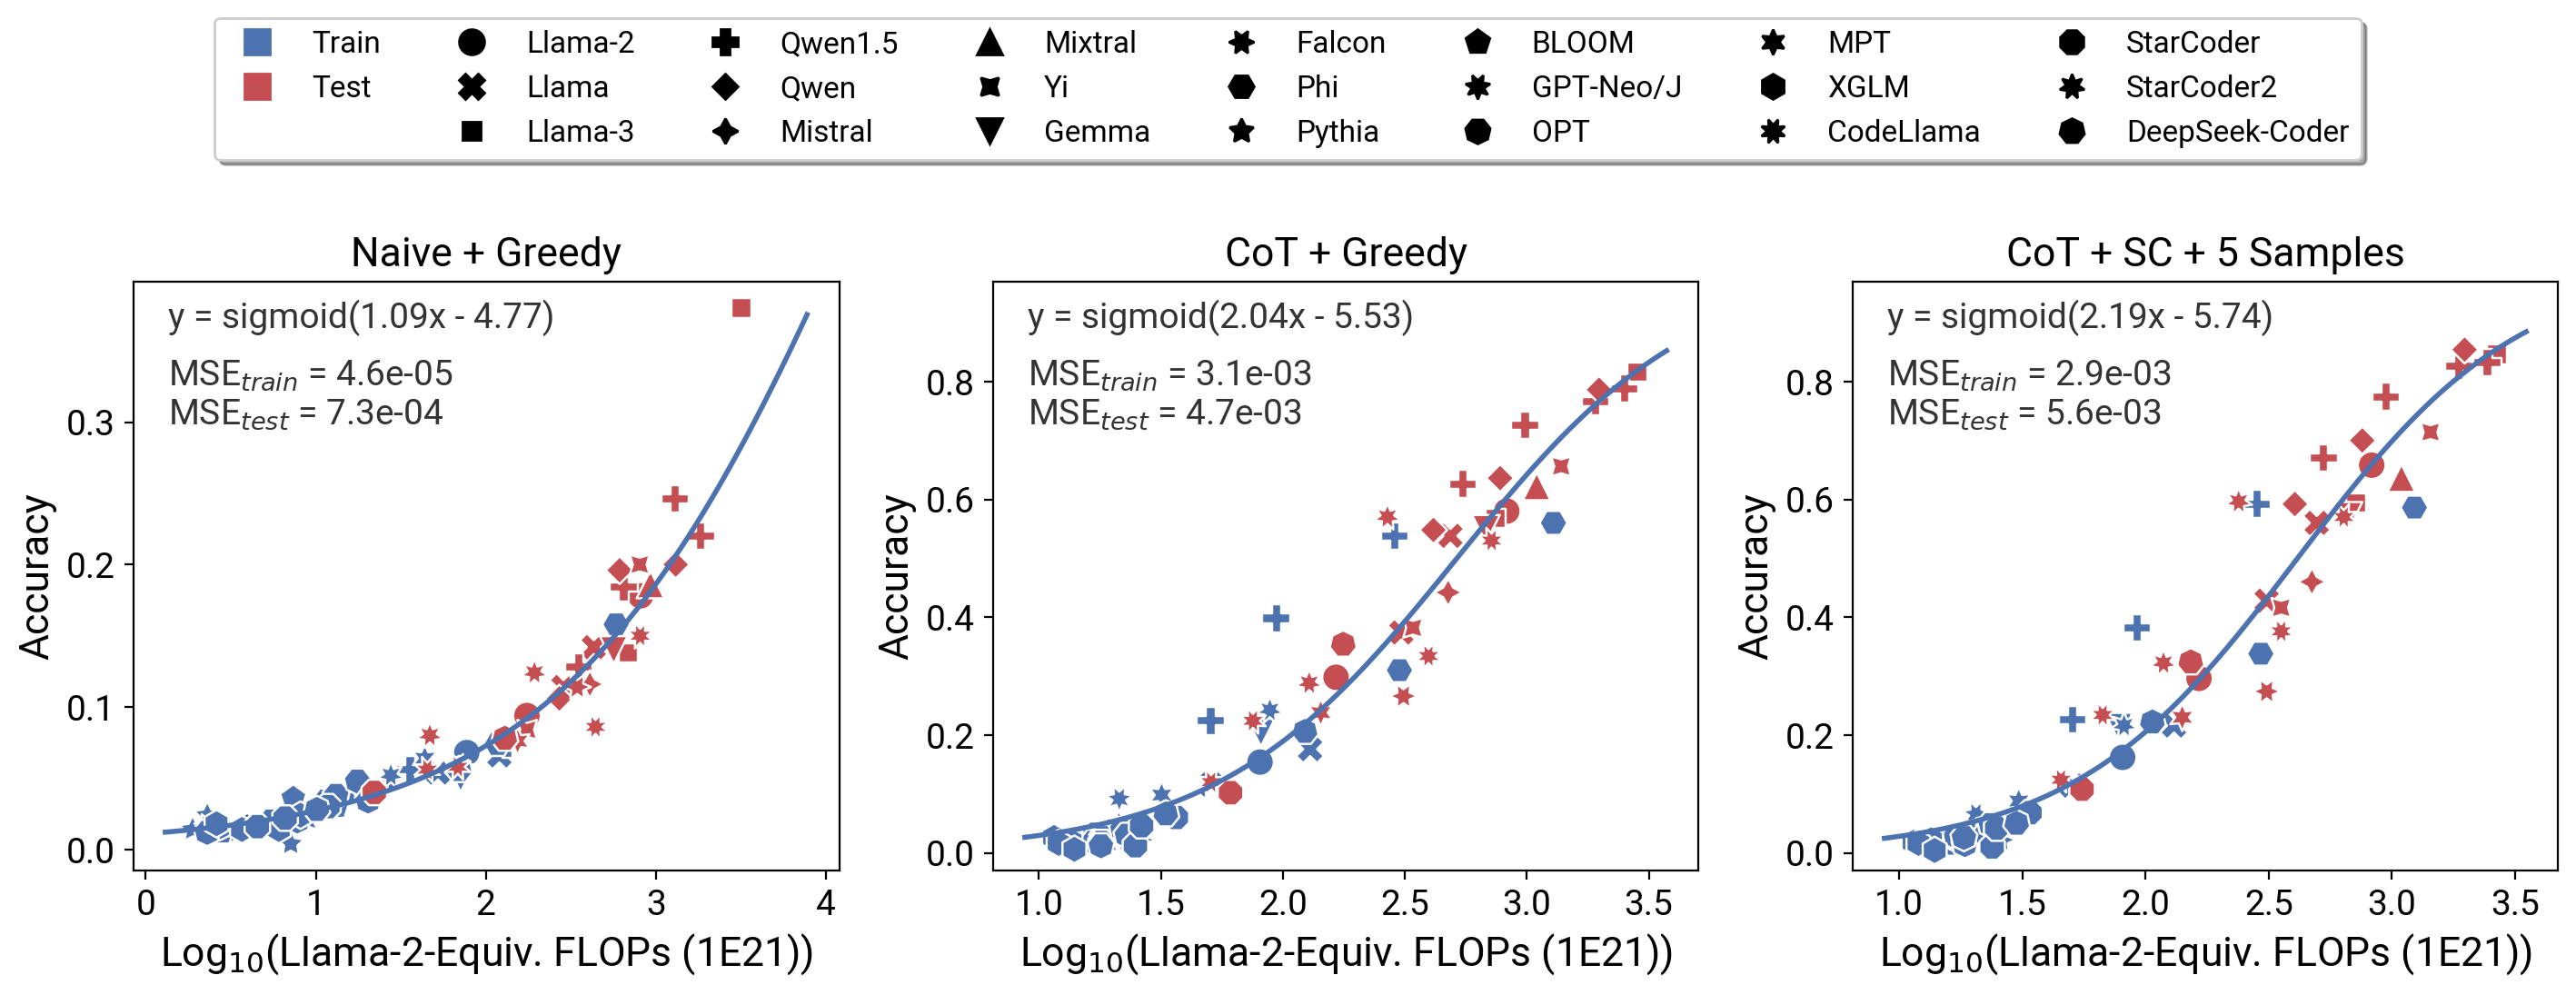

In [12]:
for x_metrics in PLOT_X_METRICS_LIST:
    fig = plot_multi_scaling_predictions(
        base_llm_eval_with_post_training, GSM8K_METHOD_SCALING_METRICS, [x_metrics], 
        SCALING_SETUP_KWARGS, y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS,
        plot_legend=True, legend_nrow=3, legend_font_size=12, add_dummy_labels=1
    )

Compare the scaling of base LLM performance with and without post-training methods

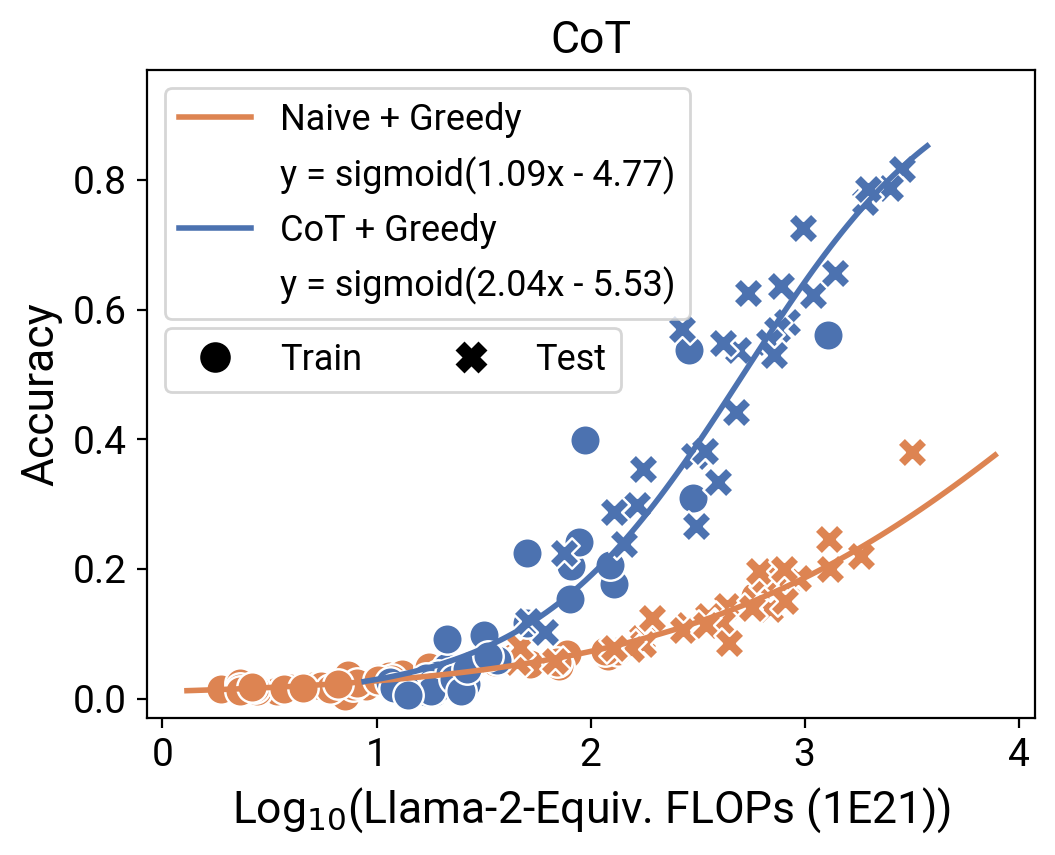

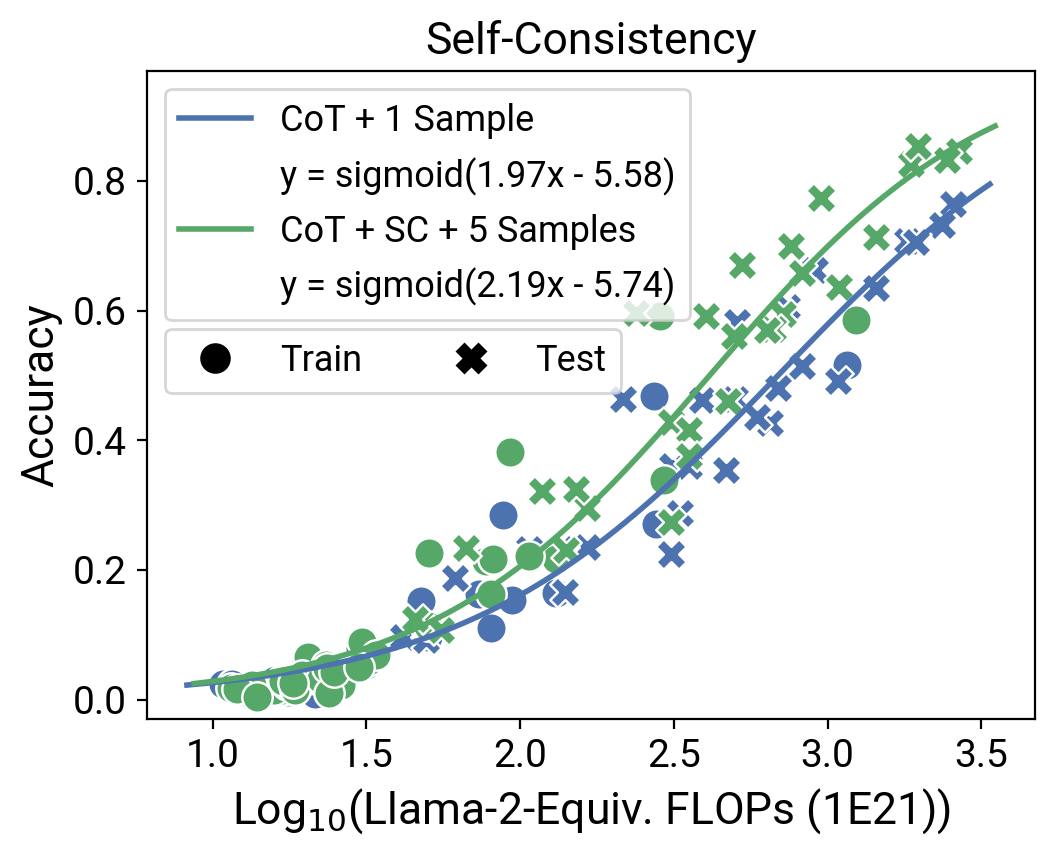

In [13]:
fig = plot_scaling_comparison_multi_metrics(
    base_llm_eval_with_post_training, GSM8K_COT_SCALING_METRICS, [PC_METRIC_NUM_3], 
    SCALING_SETUP_KWARGS, y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS,
    ymetric2title_map=GSM8K_METHOD_SCALING_ORIG_METRIC_MAP, ymetric2color_map=GSM8K_METHOD_SCALING_COLOR_MAP,
    plot_title="CoT"
)

fig = plot_scaling_comparison_multi_metrics(
    base_llm_eval_with_post_training, GSM8K_SELFCONS_SCALING_METRICS, [PC_METRIC_NUM_3], 
    SCALING_SETUP_KWARGS, y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS, 
    ymetric2title_map=GSM8K_METHOD_SCALING_ORIG_METRIC_MAP, ymetric2color_map=GSM8K_METHOD_SCALING_COLOR_MAP,
    plot_title="Self-Consistency",
)

Comparing the scaling across different model families

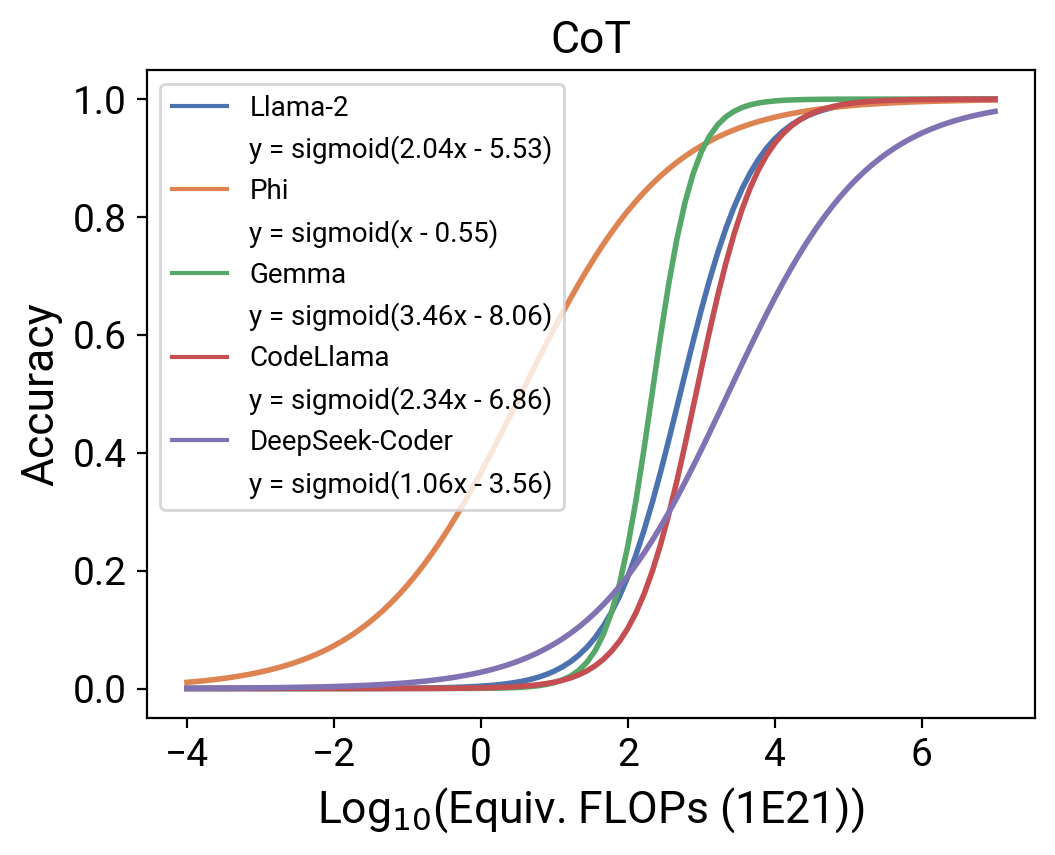

In [14]:
GSM8K_REF_FAMILY_COMPARE = ["Llama-2", "Phi", "Gemma", "CodeLlama", "DeepSeek-Coder"]
GSM8K_REF_FAMILY_COMPARE_SETUP_KWARGS = SCALING_SETUP_KWARGS.copy()
GSM8K_REF_FAMILY_COMPARE_SETUP_KWARGS["plot_adjust_kwargs"] = {"title": "CoT", "ylabel": "Accuracy", "xlabel": "Log$_{{10}}$(Equiv. FLOPs (1E21))"}

fig = plot_scaling_comparison_multi_families(
    base_llm_eval_with_post_training, GSM8K_COT_SCALING_METRICS[1], [PC_METRIC_NUM_3], GSM8K_REF_FAMILY_COMPARE, 
    GSM8K_REF_FAMILY_COMPARE_SETUP_KWARGS, title_off=True, plot_xrange=[-4, 7]
)

#### Robustness Analysis

The effect of PCs: compare the scaling predictions using different number of PCs and with training FLOPs as baseline

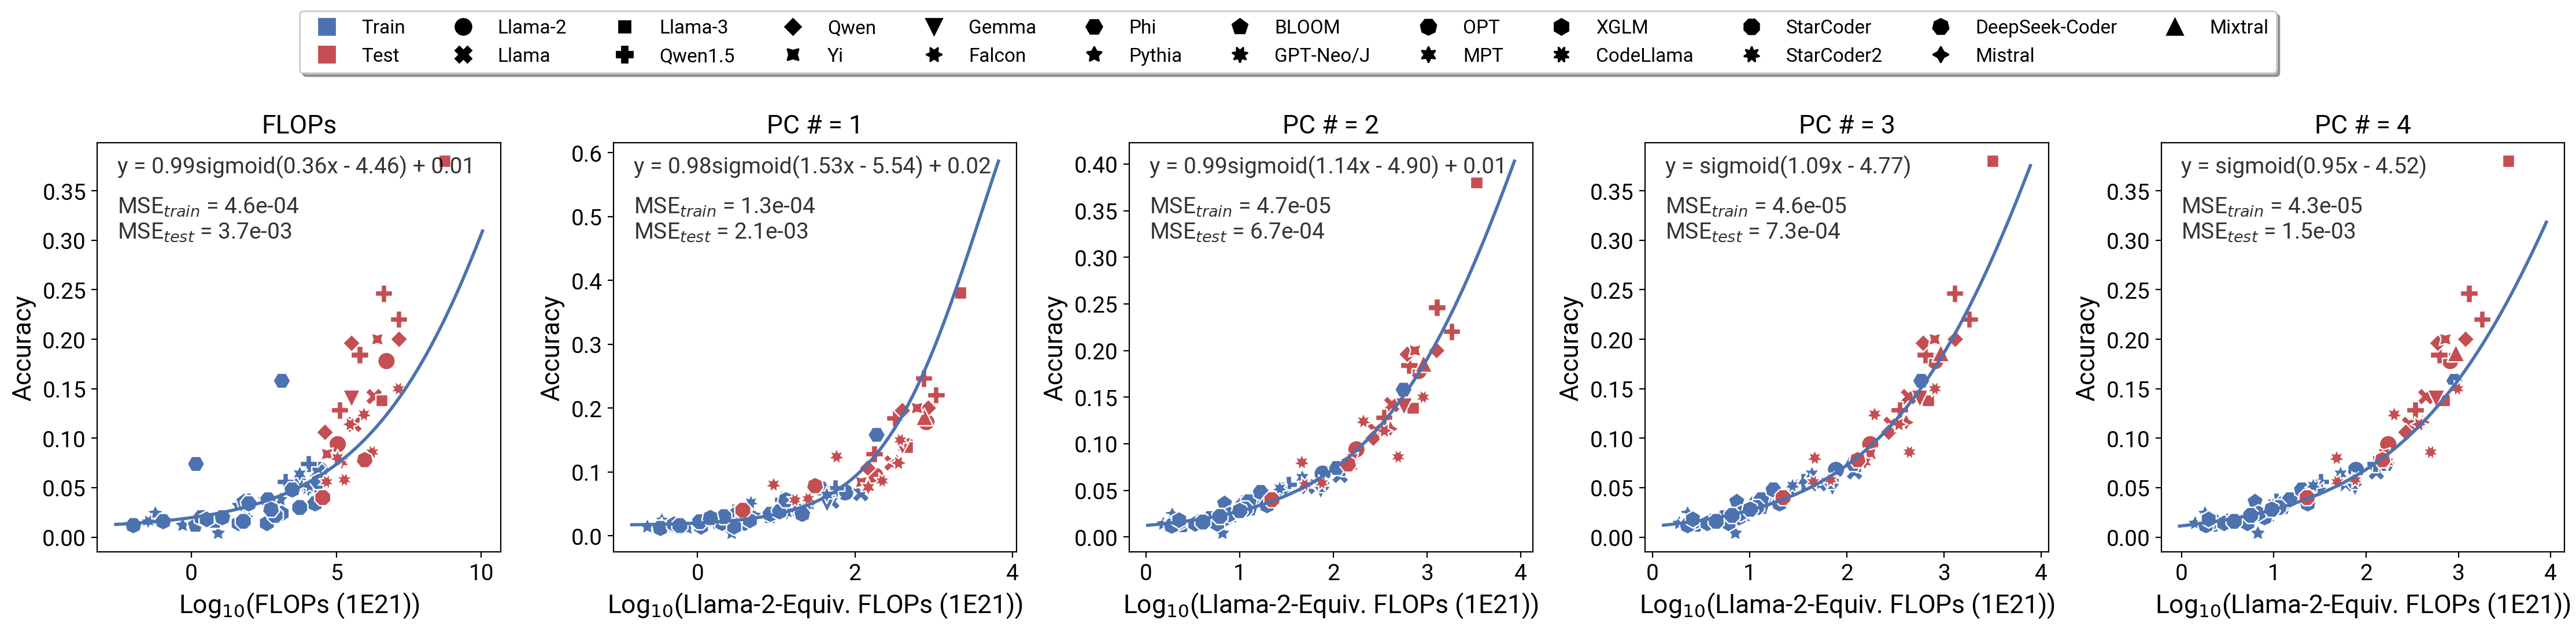

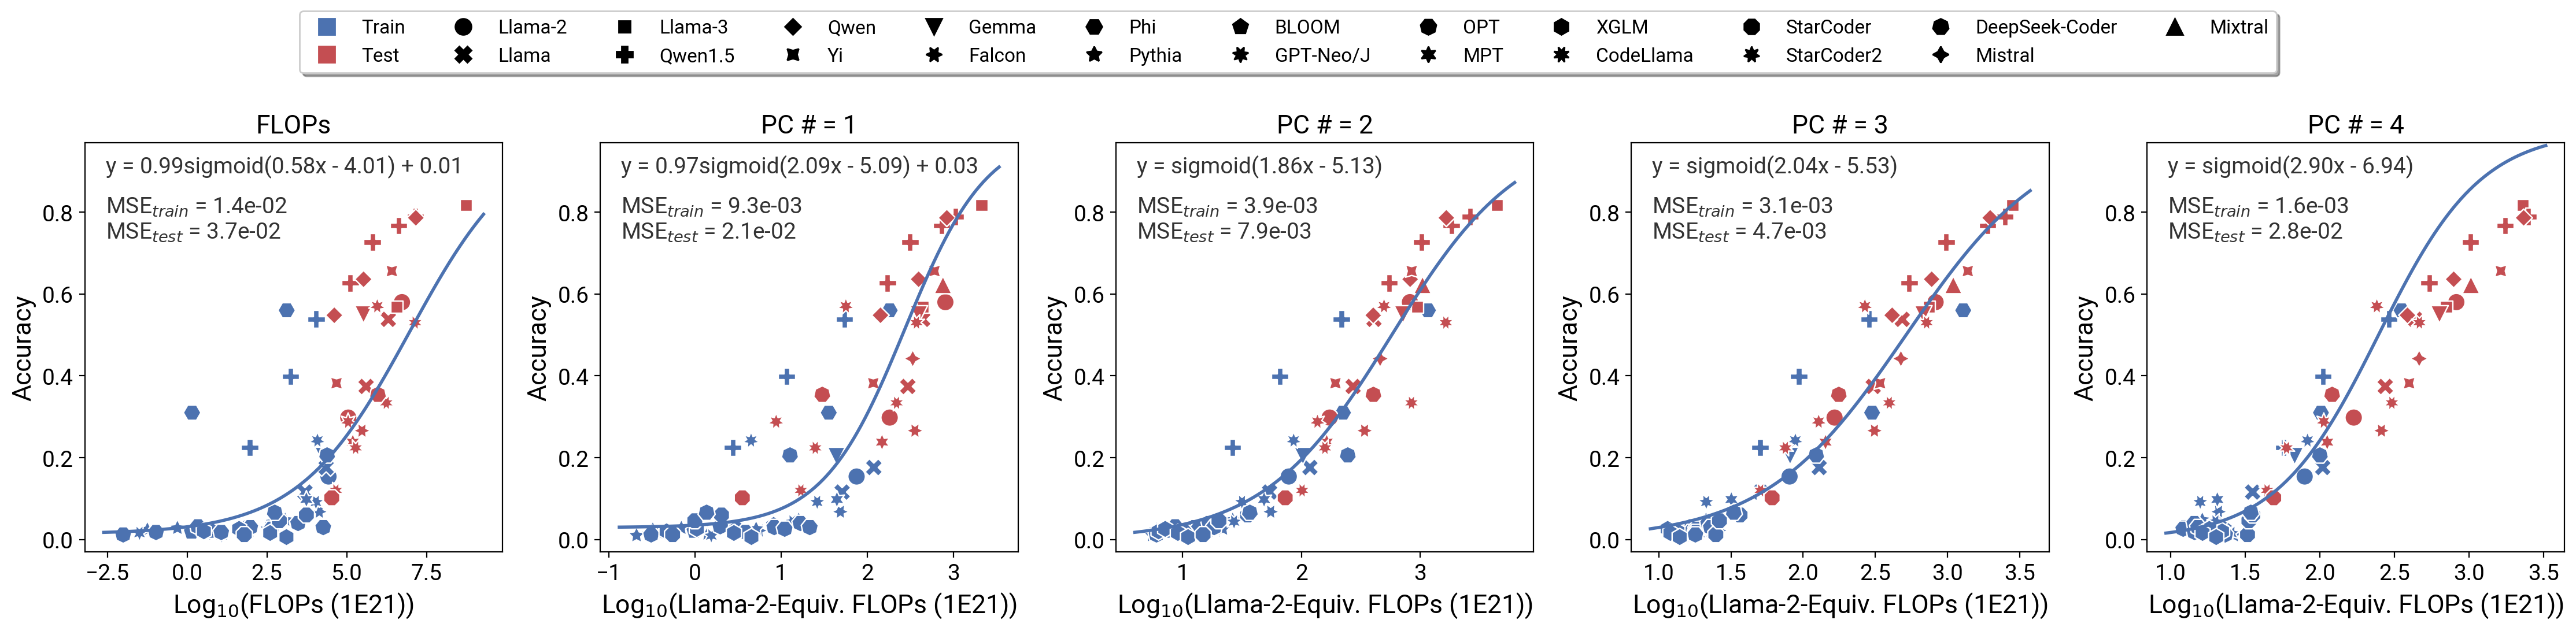

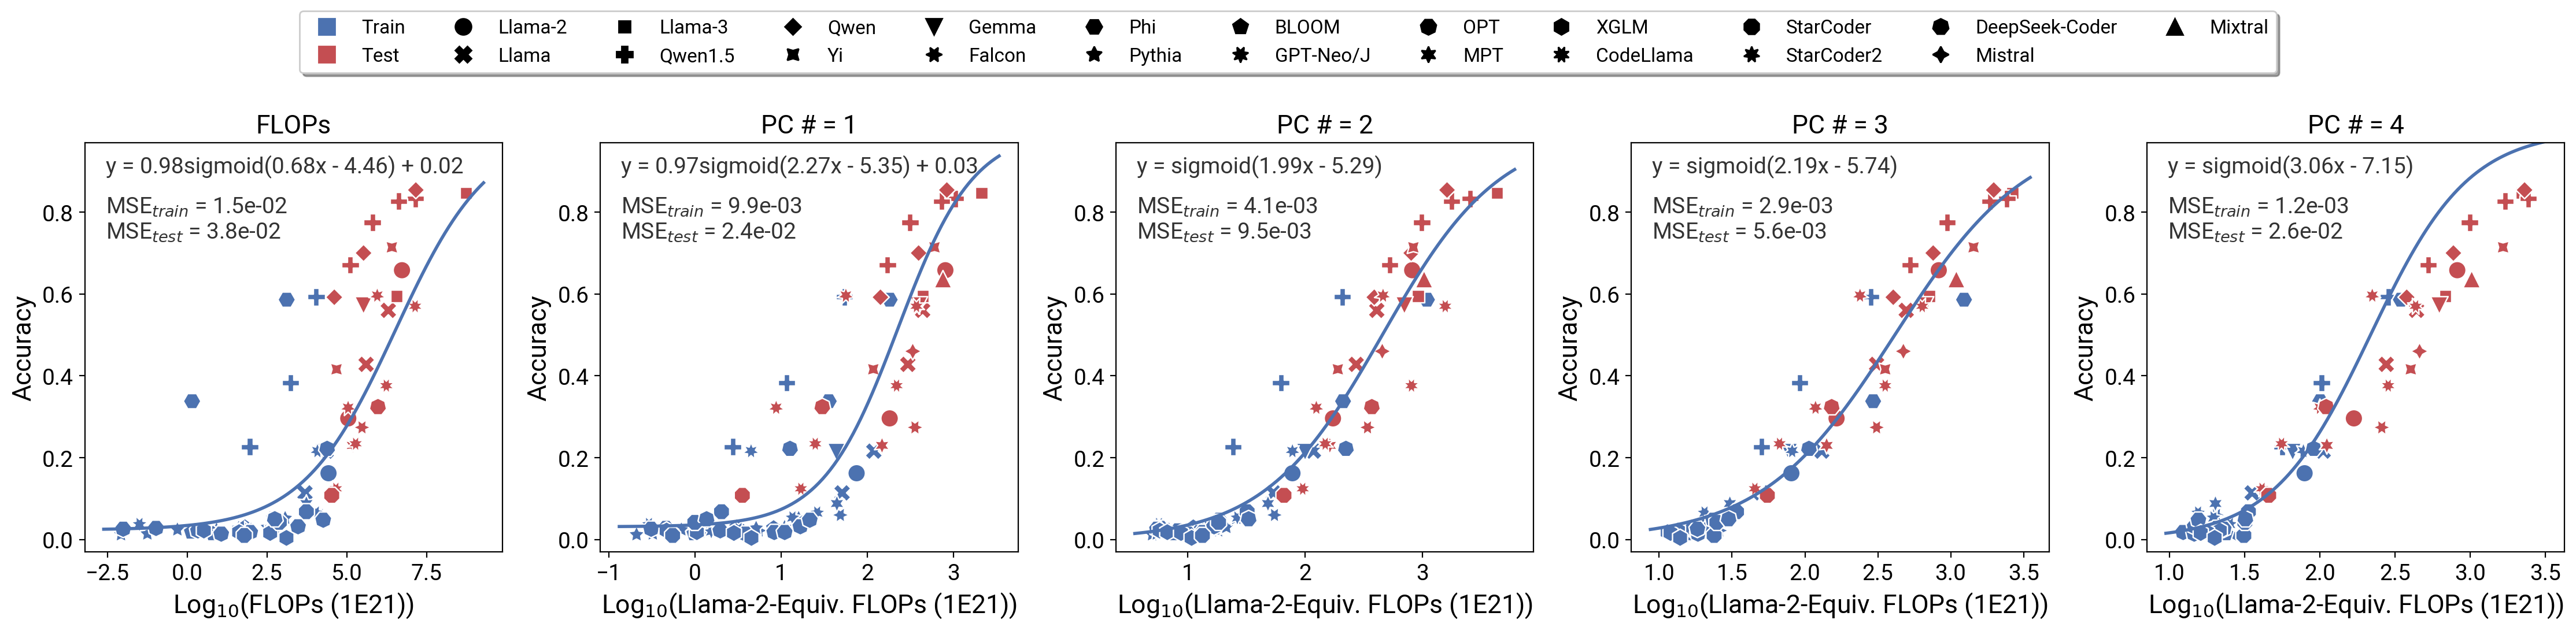

In [15]:
DIFF_PC_NUM_PLOT_X_METRICS_LIST = [TRAINING_FLOPS_METRIC, PC_METRIC_NUM_1, PC_METRIC_NUM_2, PC_METRIC_NUM_3, PC_METRIC_NUM_4]

for y_metric in GSM8K_METHOD_SCALING_METRICS:
    fig = plot_multi_scaling_predictions(
        base_llm_eval_with_post_training, [y_metric], DIFF_PC_NUM_PLOT_X_METRICS_LIST, SCALING_SETUP_KWARGS, 
        y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS,
        plot_legend=True, 
        legend_nrow=2, legend_font_size=12, add_dummy_labels=0, 
        transpose=True
    )

The effect of cutoff: vary the FLOPs cutoff, plot the test MSE, and compute the mean test MSE (area under the error curve)

3it [09:42, 194.06s/it]


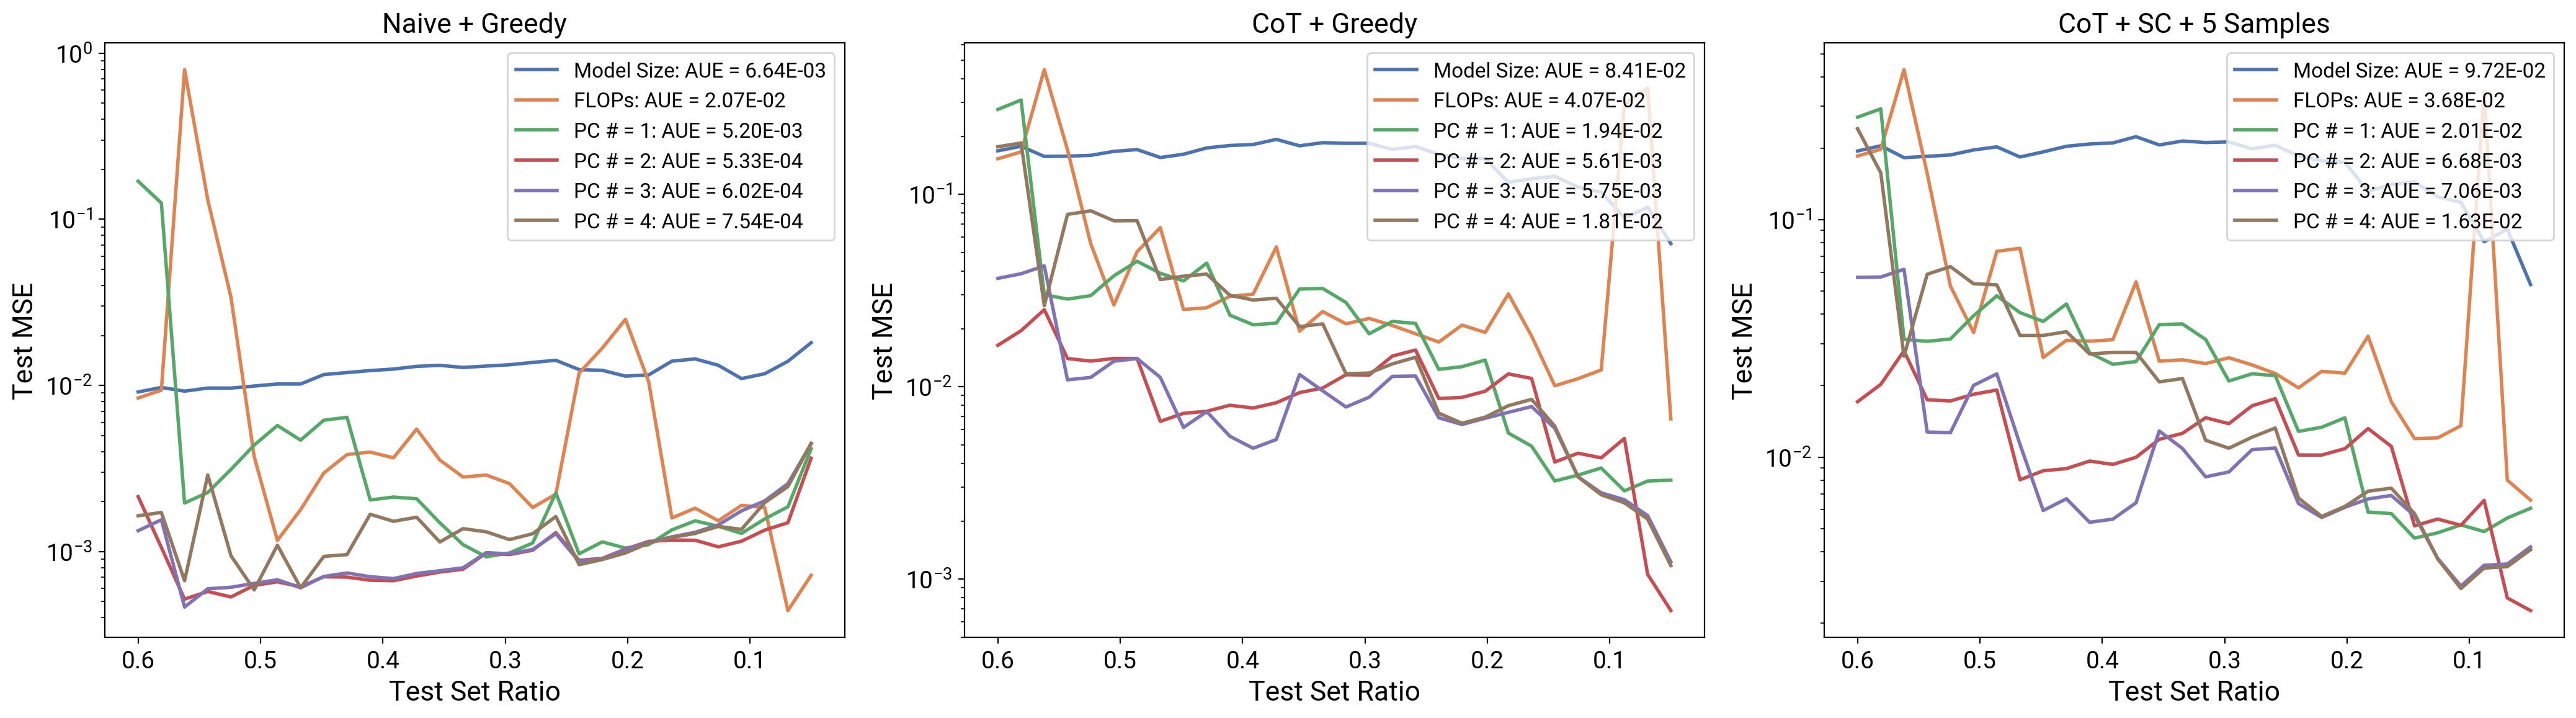

In [16]:
# vary the FLOPs cutoff to change test size from 0.6 to 0.05
rank_metric_name = "FLOPs (1E21)"
split_limit_ranges = np.linspace(0.6, 0.05, 30)

regress_metrics_to_plot = ['mse_test']

setup_kwargs = copy.deepcopy(SCALING_SETUP_KWARGS)
setup_kwargs.pop("df_filter")  # need to be poped as it is not pickable for multiprocessing

fig = plot_reg_metric_curves(
    base_llm_eval_with_post_training,
    ALL_X_METRICS_LIST,
    GSM8K_METHOD_SCALING_METRICS,
    rank_metric_name,
    split_limit_ranges,
    regress_metrics_to_plot,
    setup_kwargs,
    ymetric2title_map=GSM8K_METHOD_SCALING_ORIG_METRIC_MAP,
    filter_model_family=EVAL_BASE_MODEL_FAMILIES,   # added back for filtering
)

### BBH - CoT

#### Setup

Specify downstream metrics for analysis

In [17]:
## Note: BBH task named by "bbh_{fewshot|cot_fewshot}_{subtask|overall}_3_exact_match,flexible-extract[,norm]"
##       where "overall" is the arverage of all subtasks, and ",norm" means normalized by random performance

PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP = {
    "bbh_fewshot_overall_3_exact_match,flexible-extract,norm": "Naive - Greedy",
    "bbh_cot_fewshot_overall_3_exact_match,flexible-extract,norm": "CoT - Greedy",
}
PLOT_BBH_METHOD_SCALING_METRICS = list(PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP.keys())

color_palette = sns.color_palette()

PLOT_BBH_METHOD_SCALING_COLOR_MAP = {
    'bbh_fewshot_overall_3_exact_match,flexible-extract,norm': color_palette[1],
    'bbh_cot_fewshot_overall_3_exact_match,flexible-extract,norm': color_palette[0],
}


Plot styling

In [18]:
PLOT_BBH_SETUP_SPECIFIC_KWARGS = {}
for e in PLOT_BBH_METHOD_SCALING_METRICS:
    PLOT_BBH_SETUP_SPECIFIC_KWARGS[e] = {
        "plot_adjust_kwargs": {"title": PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
    }


#### Scaling Predictions

Compare the scaling of base LLM performance with and without post-training methods

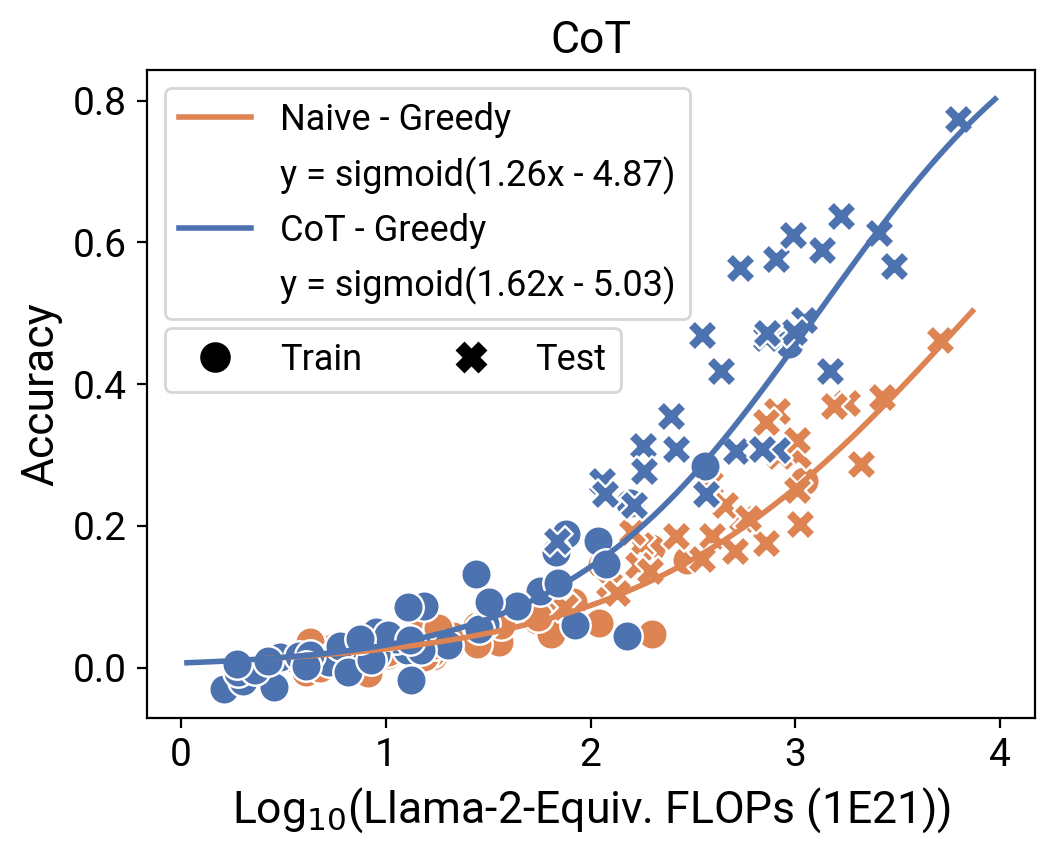

In [19]:
fig = plot_scaling_comparison_multi_metrics(
    base_llm_eval_with_post_training, PLOT_BBH_METHOD_SCALING_METRICS, [PC_METRIC_NUM_3], SCALING_SETUP_KWARGS, 
    y_metric_specific_kwargs=PLOT_BBH_SETUP_SPECIFIC_KWARGS,
    ymetric2title_map=PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP, ymetric2color_map=PLOT_BBH_METHOD_SCALING_COLOR_MAP,
    plot_title="CoT"
)